In [1]:
from env import get_db_url
import numpy as np
import pandas as pd
import os
import acquire
import prepare
import wrangle
import matplotlib.pyplot as plt
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import explore
import pydataset
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [8]:
zillow_predictions = wrangle.wrangle_zillow_predictions()
zillow_predictions.isna().sum()
zillow_categorical = wrangle.wrangle_zillow_predictions_without_drop()

In [9]:
train, validate, test = wrangle.split_data(zillow_predictions)
train

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,Los Angeles,Orange,Ventura
3958,3.0,2.0,1600.0,409260.0,1959.0,4968.19,1,0,0
38332,2.0,1.0,1638.0,126907.0,1927.0,1500.66,1,0,0
32297,4.0,2.0,1725.0,592000.0,1966.0,7380.59,1,0,0
31139,2.0,1.0,1015.0,172499.0,1925.0,2252.18,1,0,0
20188,1.0,1.0,565.0,292368.0,1915.0,3624.67,1,0,0
...,...,...,...,...,...,...,...,...,...
35558,4.0,4.0,4226.0,613350.0,1959.0,6464.74,0,0,1
8268,3.0,2.0,1534.0,380623.0,1970.0,4731.33,1,0,0
2175,2.0,1.5,1213.0,431697.0,1956.0,5451.26,0,1,0
11049,3.0,2.0,1584.0,271747.0,1959.0,3386.08,1,0,0


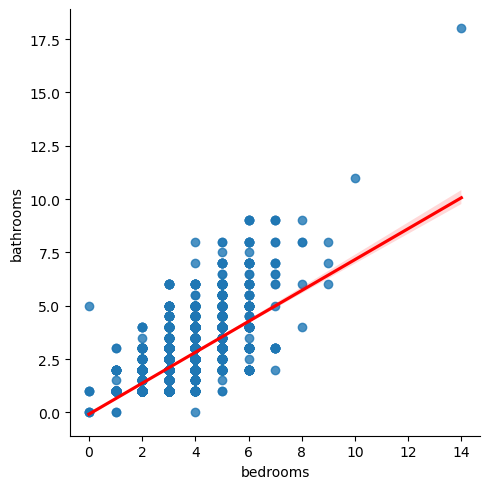

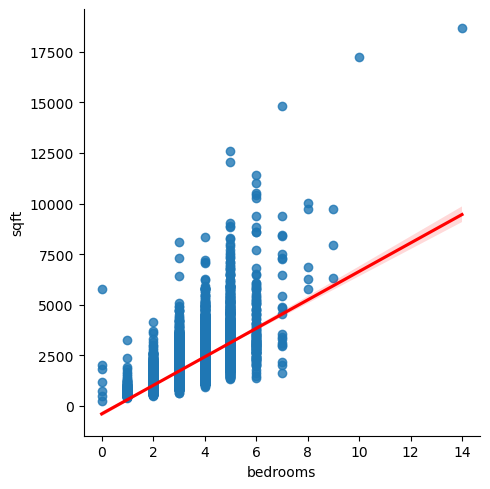

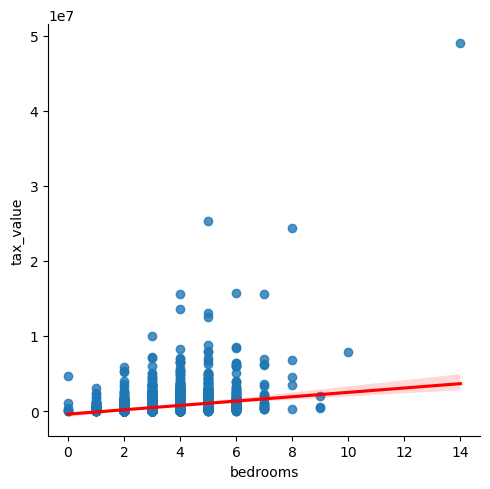

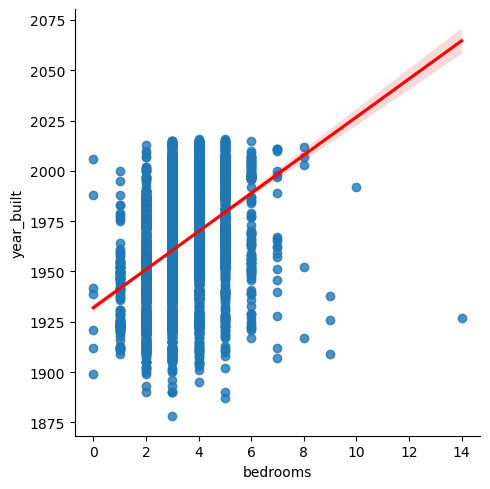

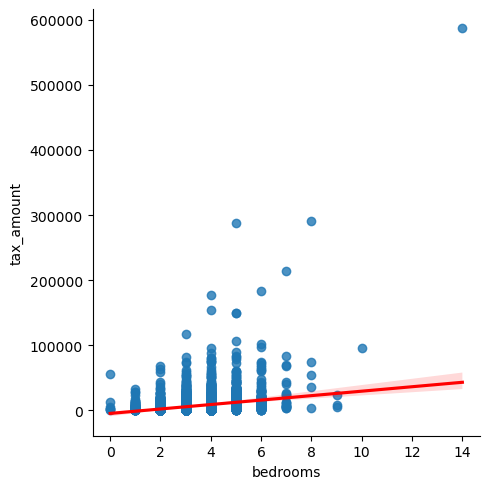

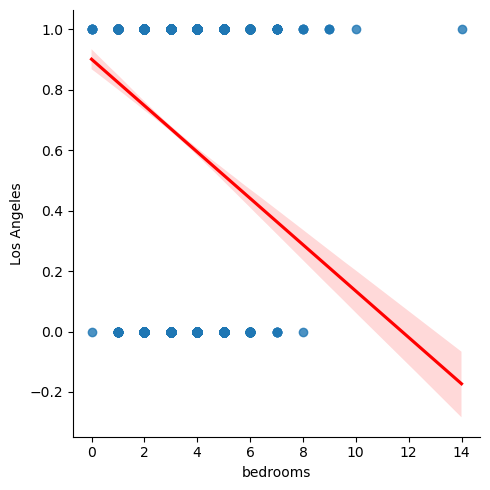

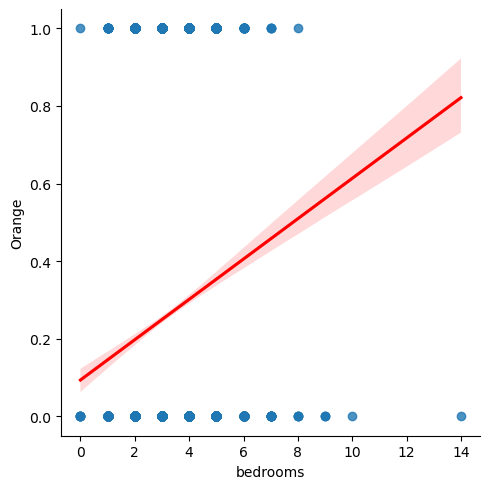

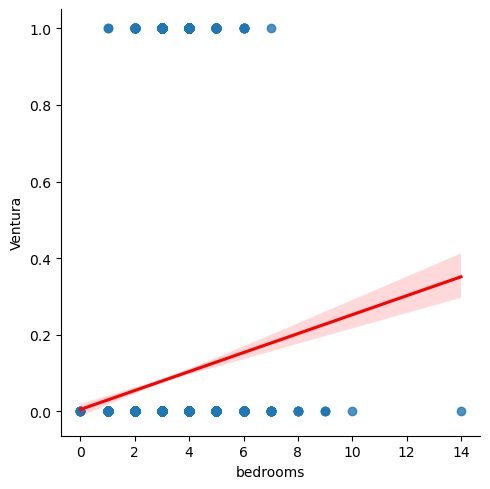

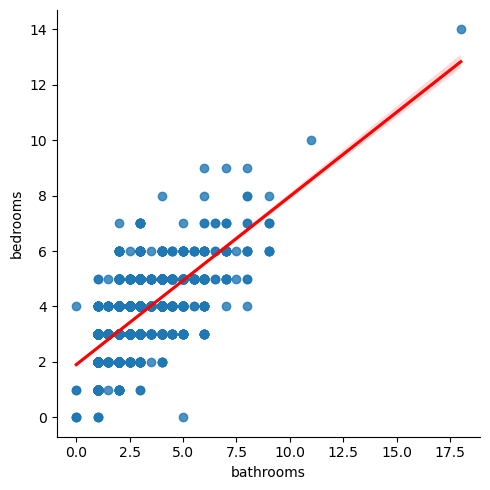

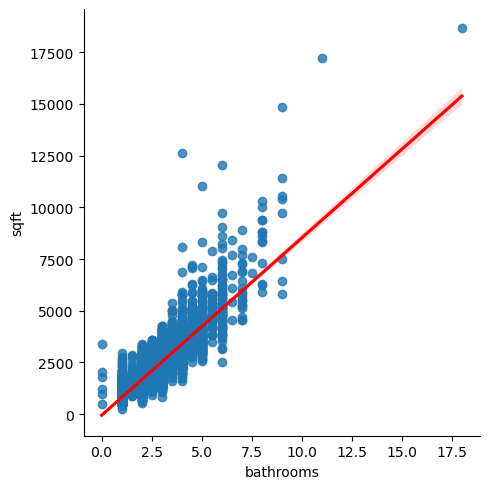

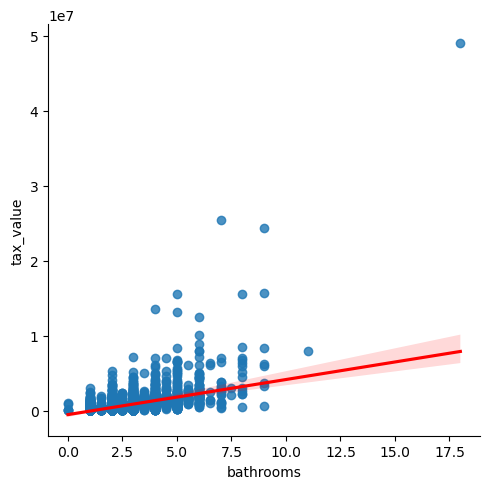

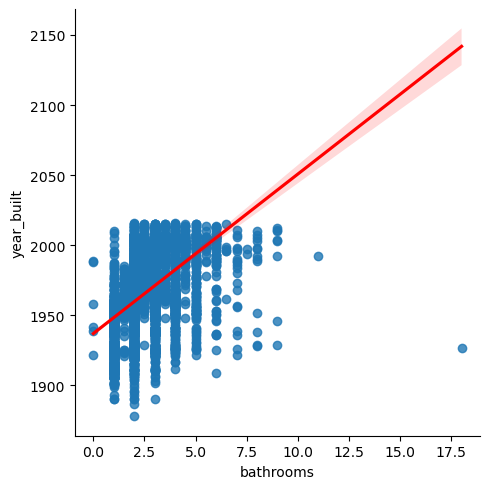

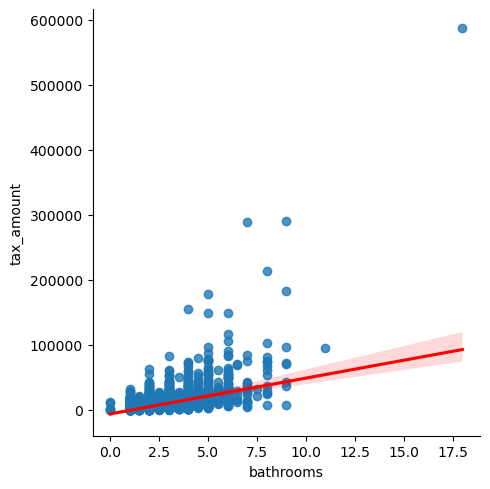

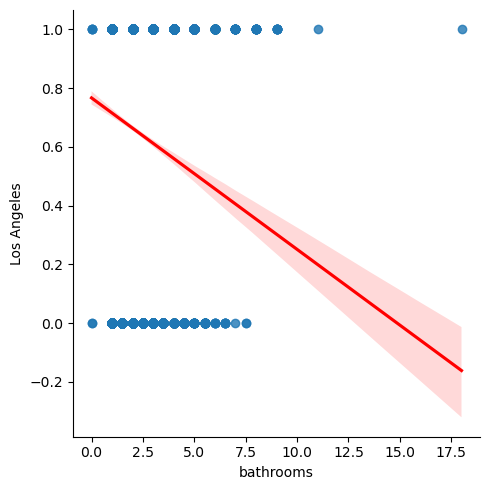

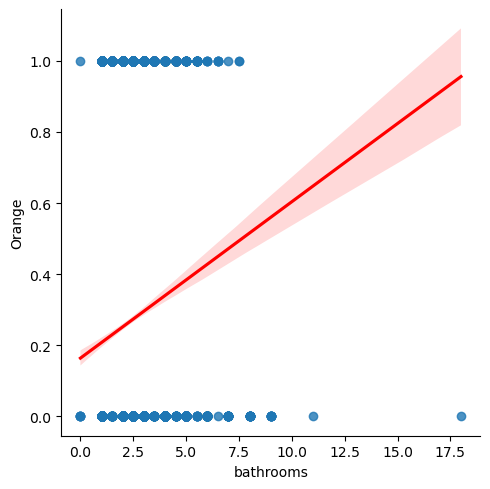

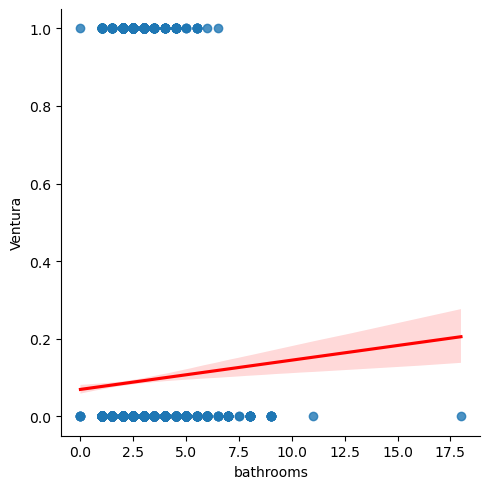

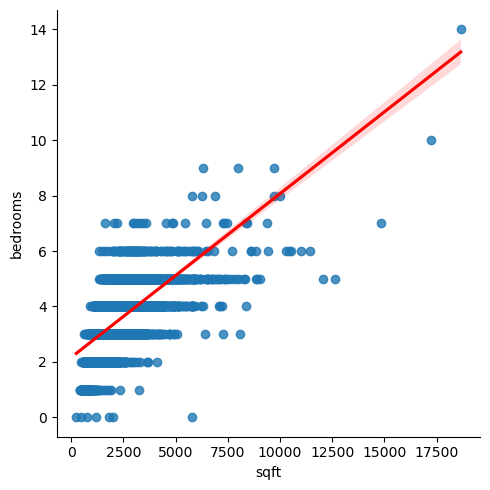

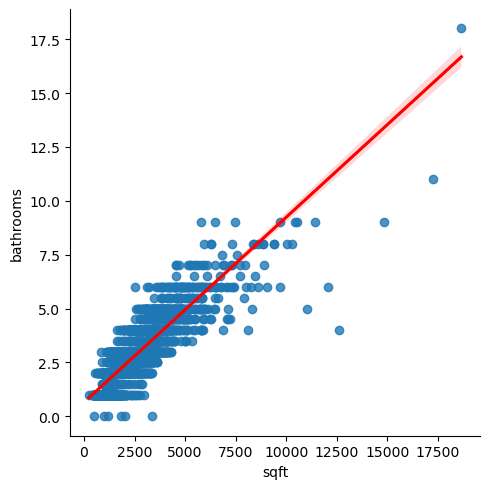

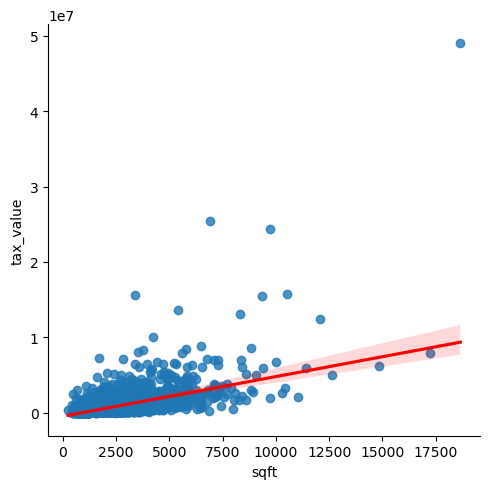

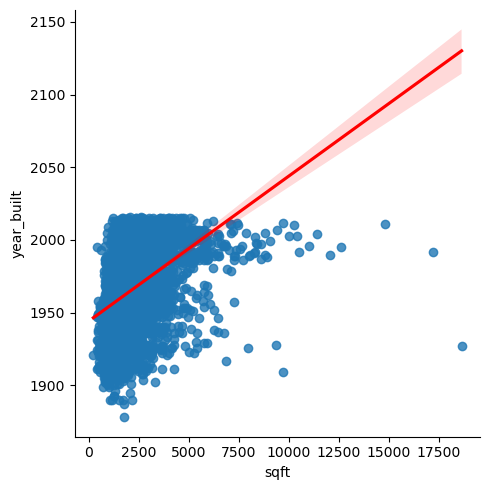

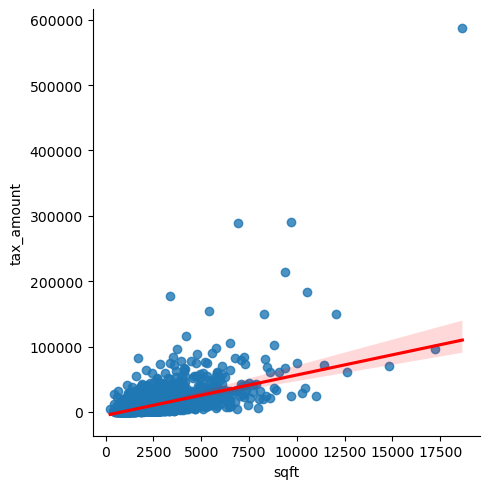

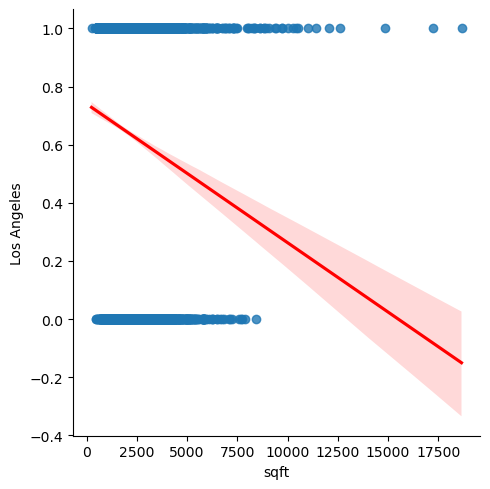

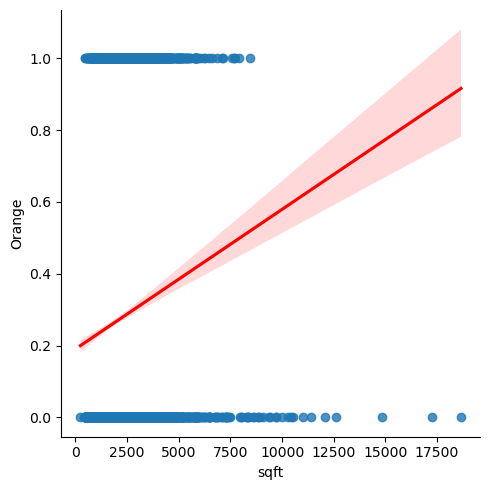

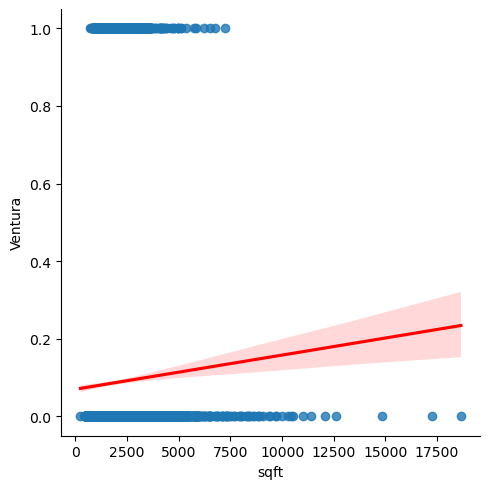

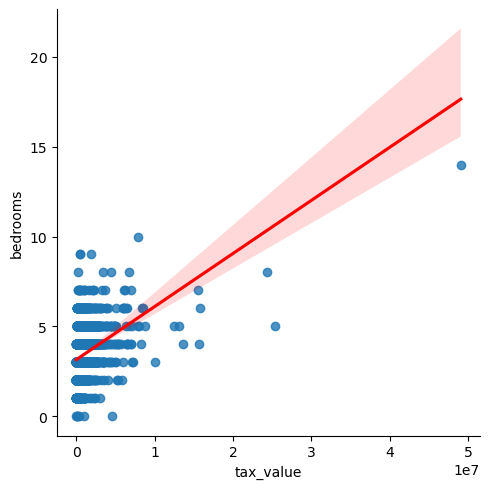

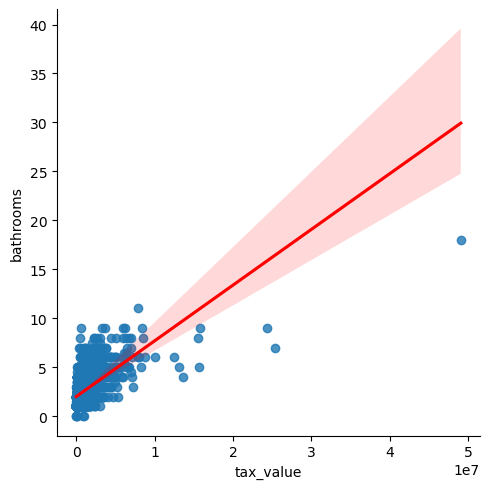

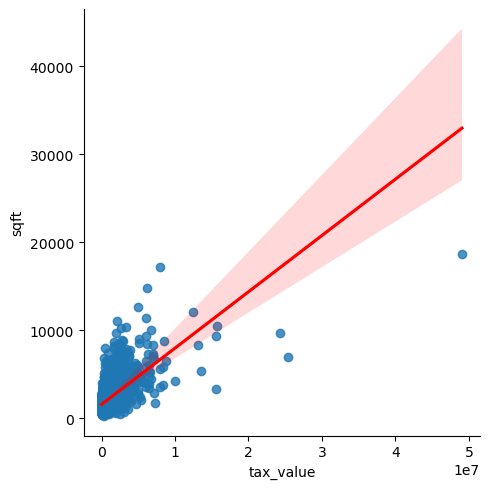

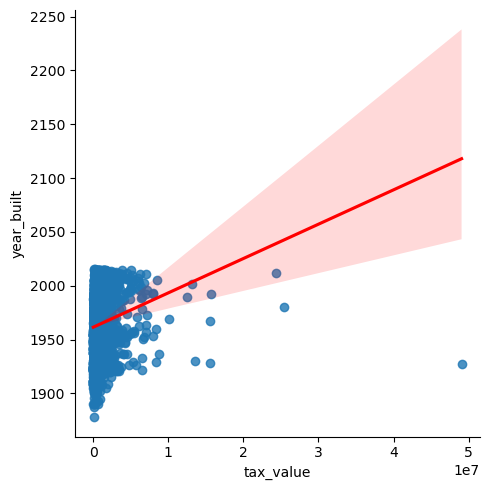

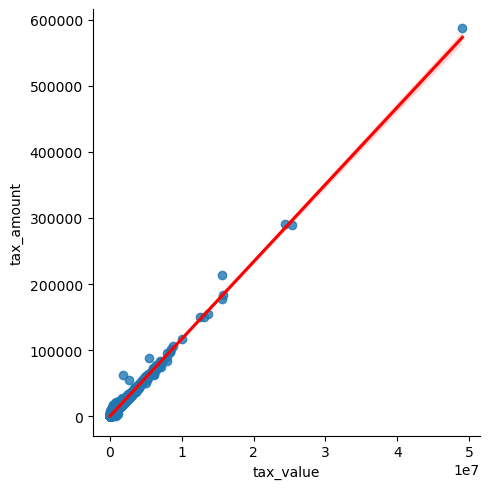

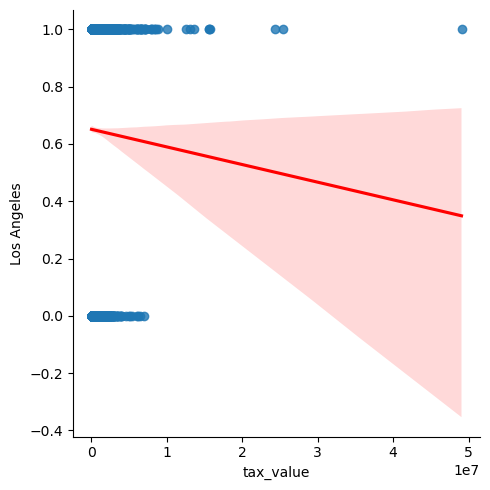

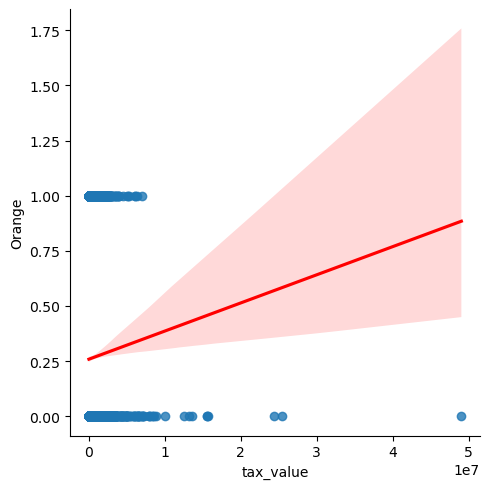

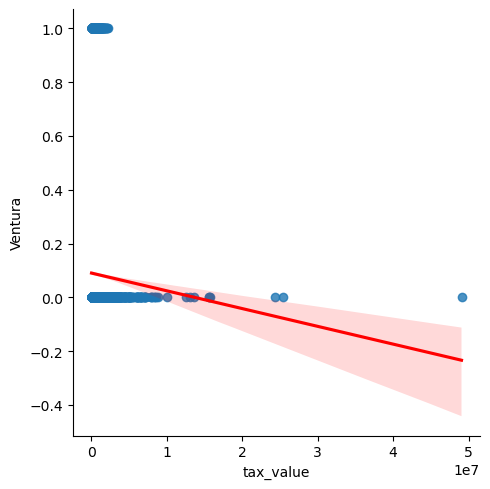

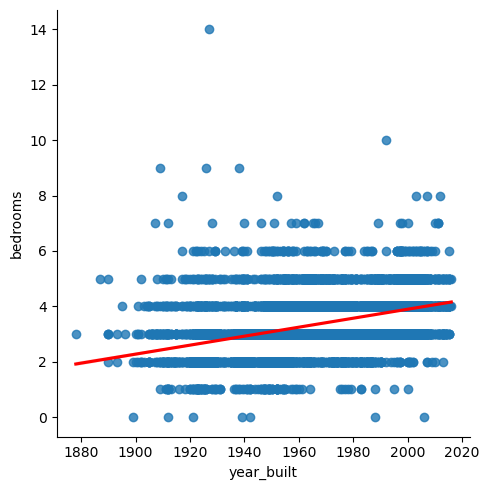

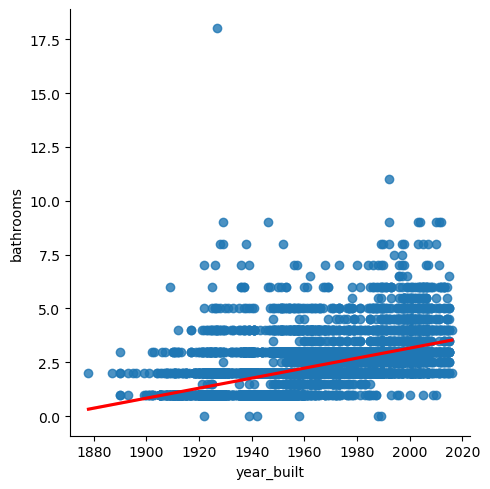

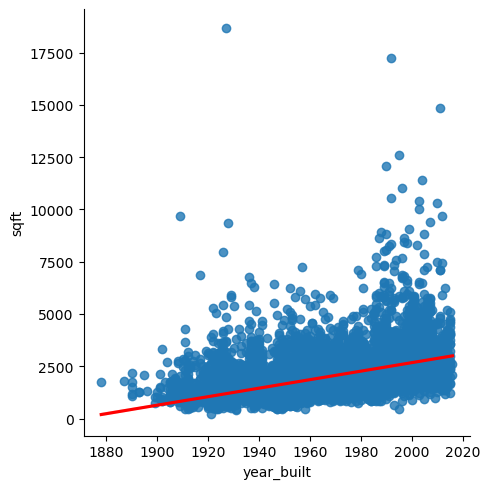

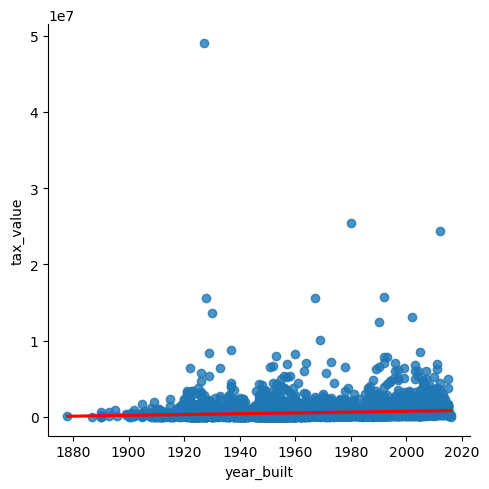

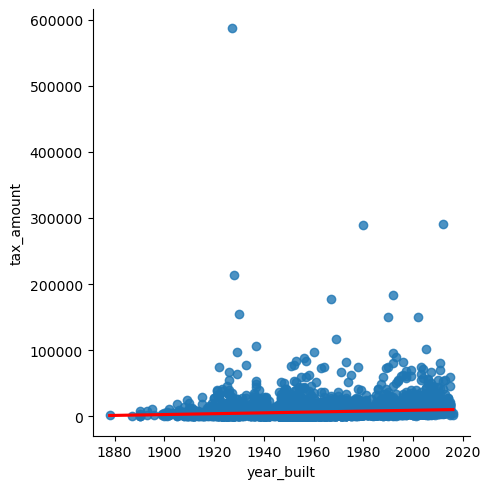

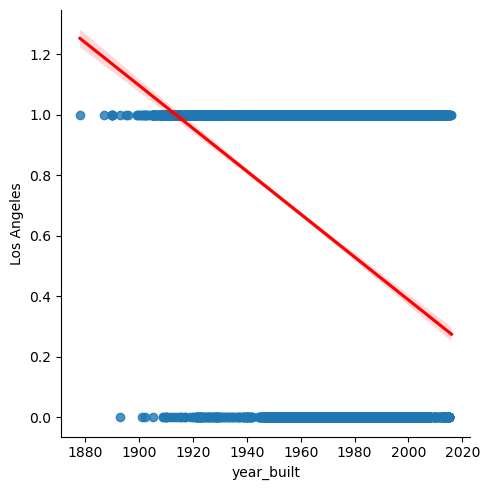

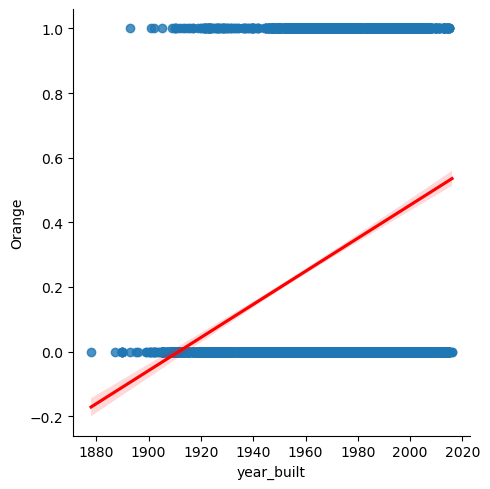

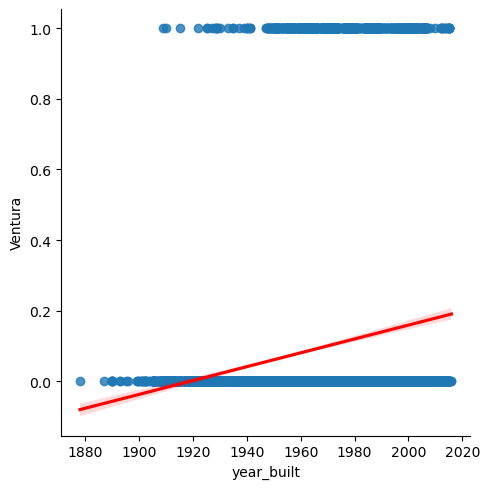

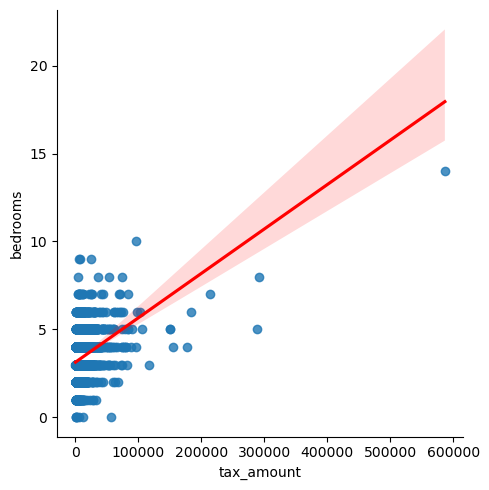

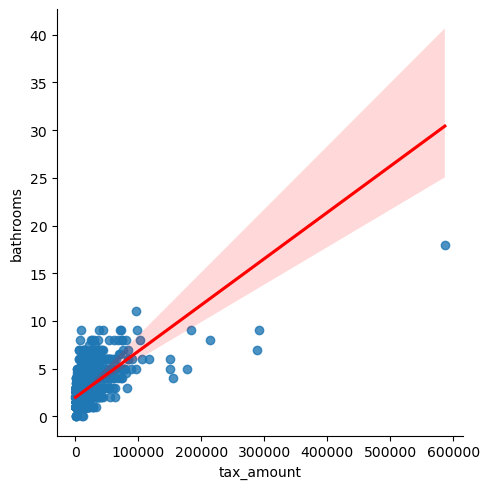

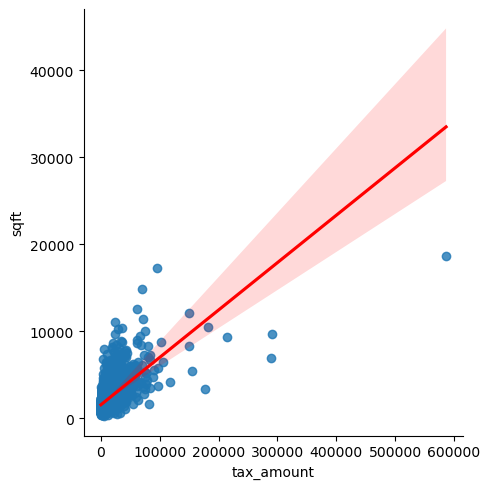

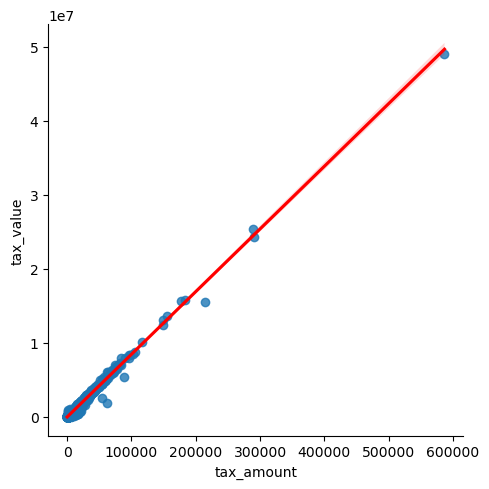

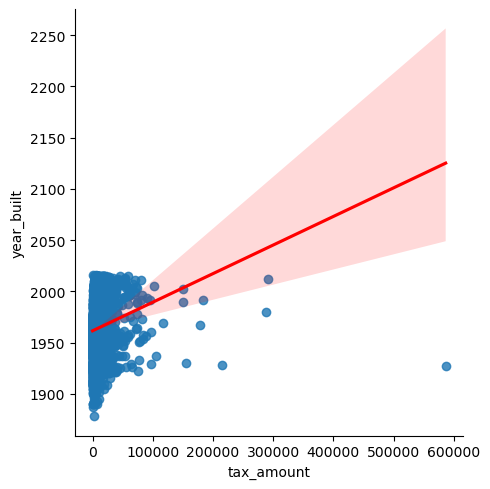

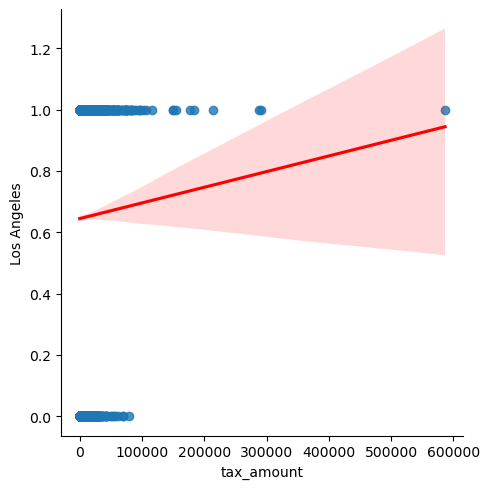

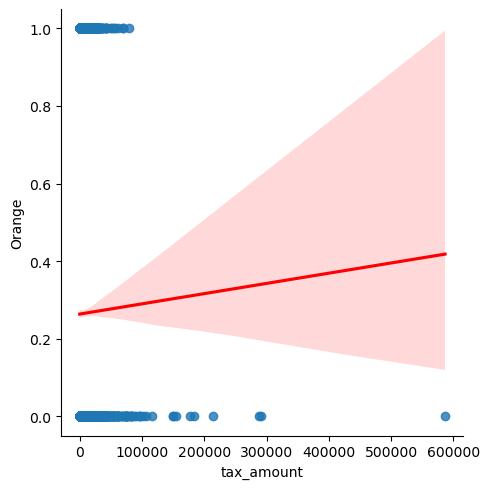

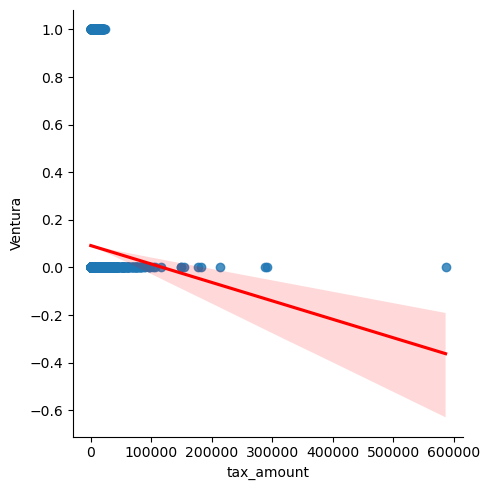

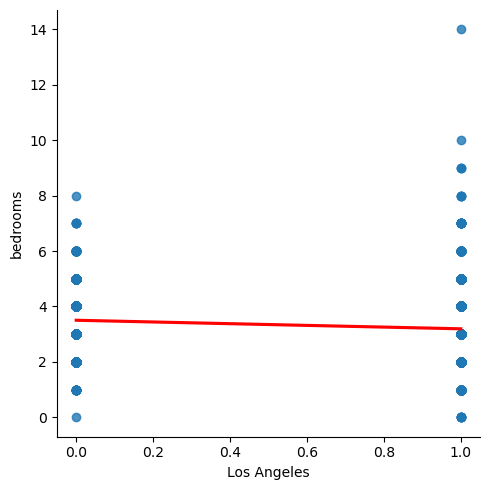

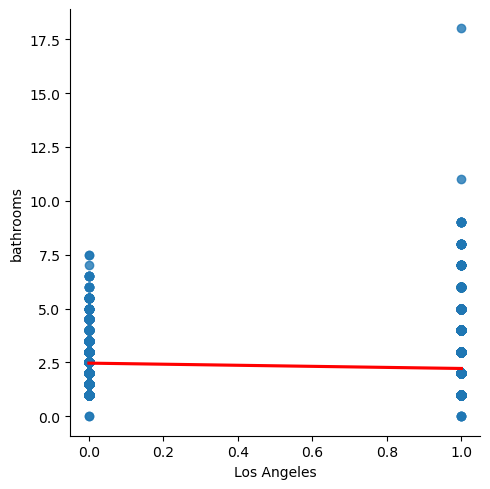

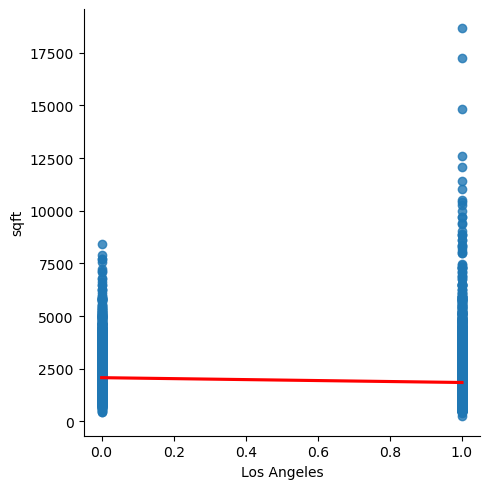

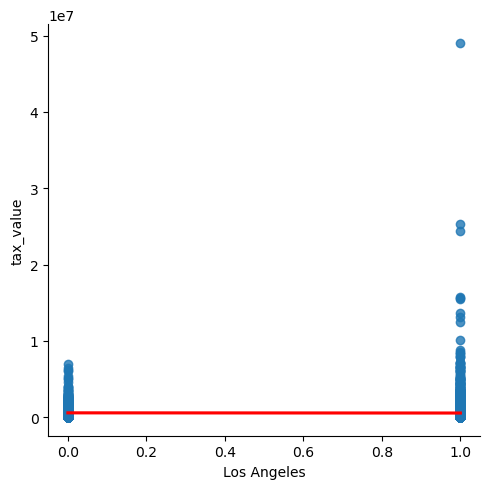

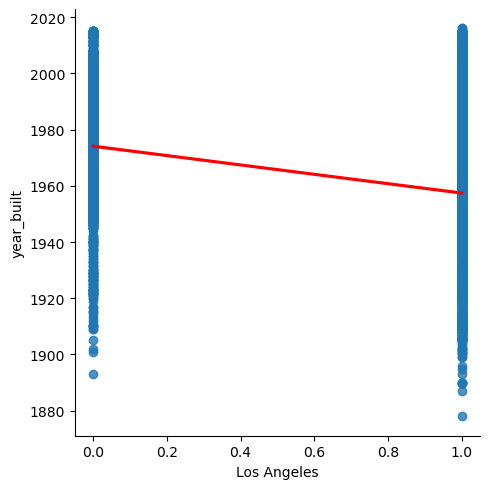

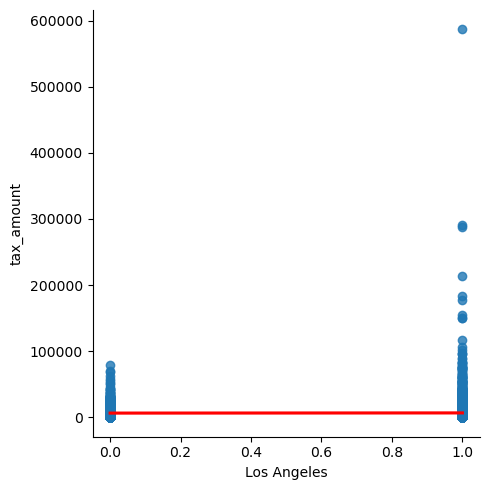

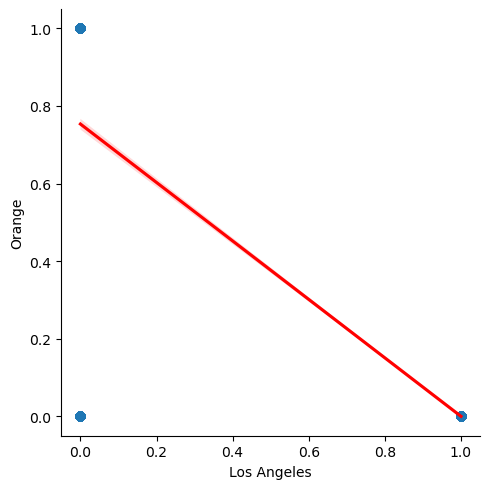

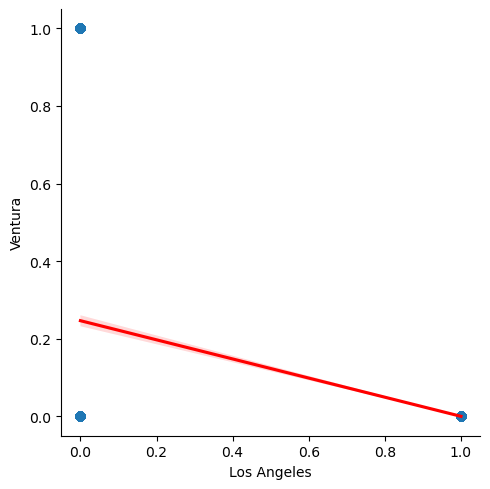

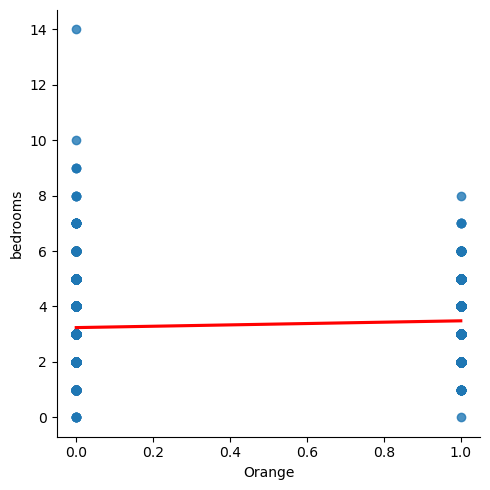

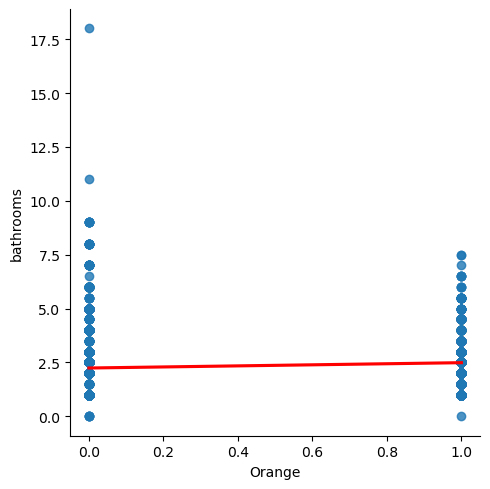

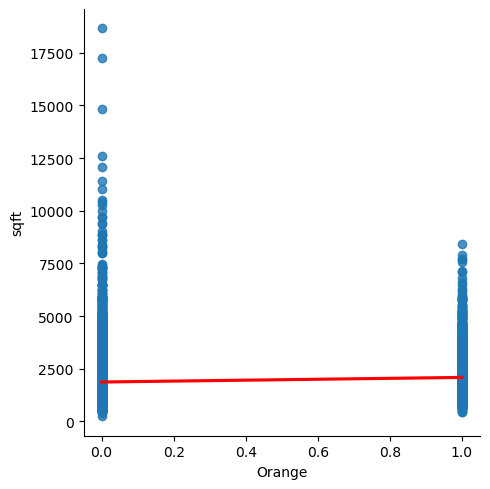

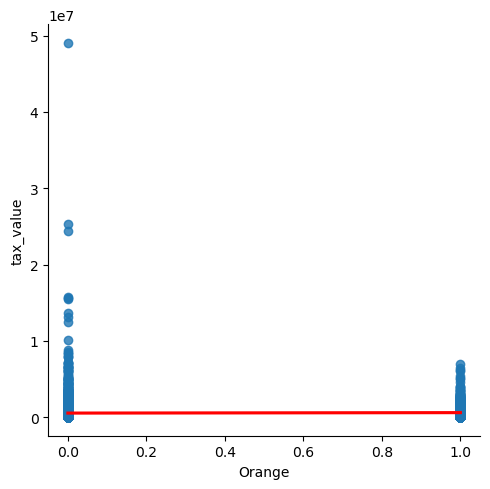

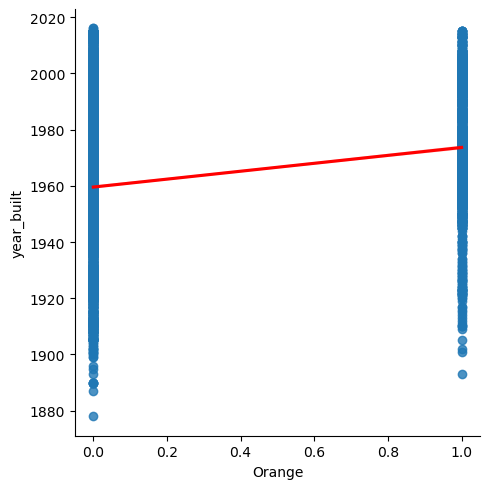

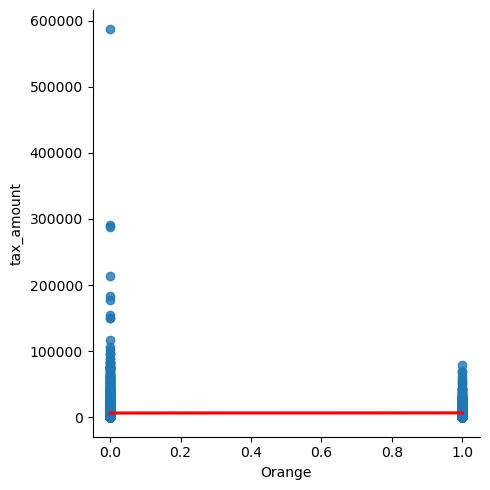

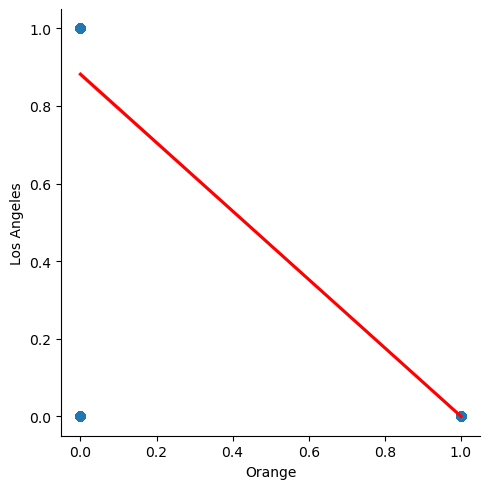

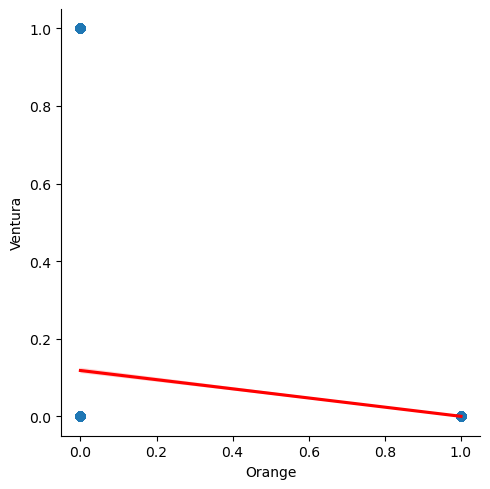

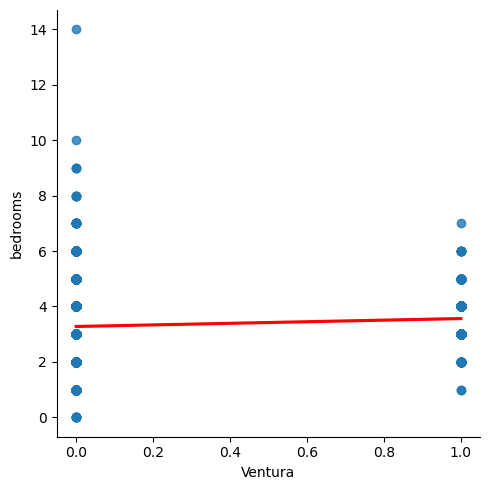

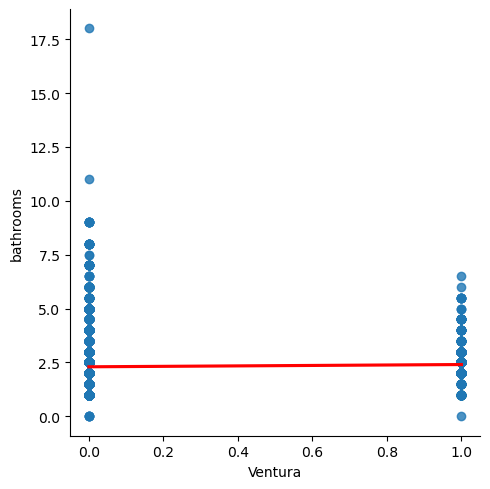

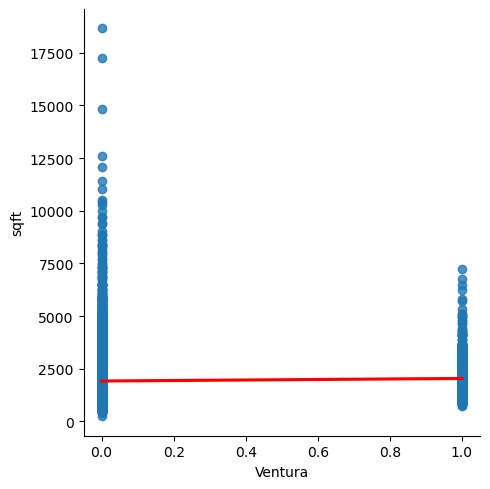

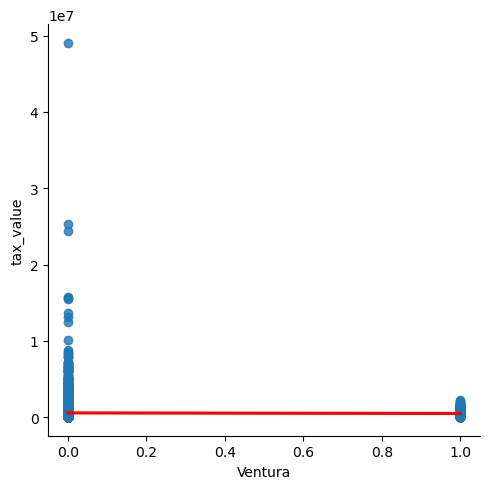

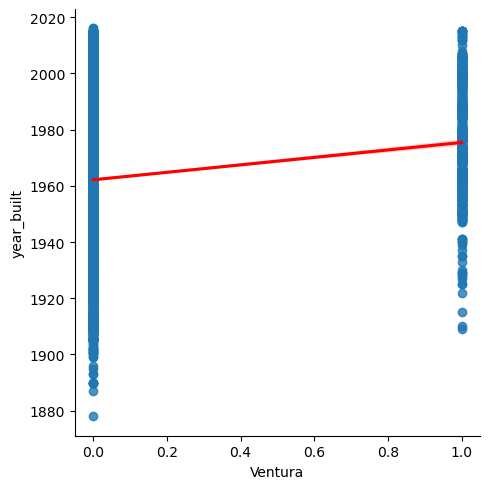

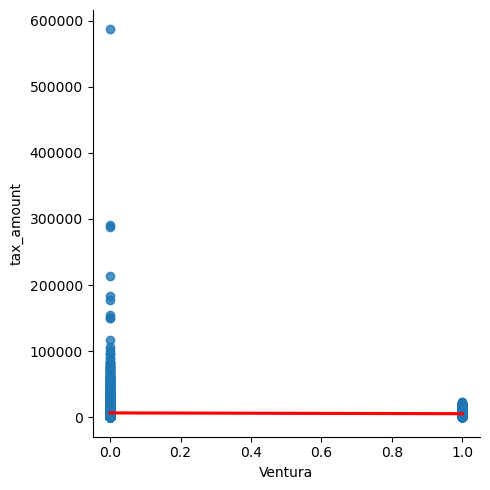

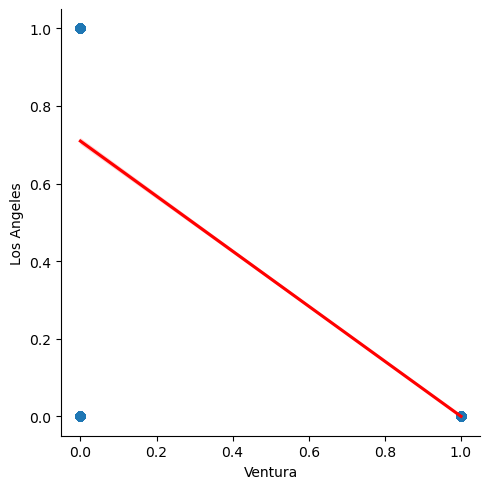

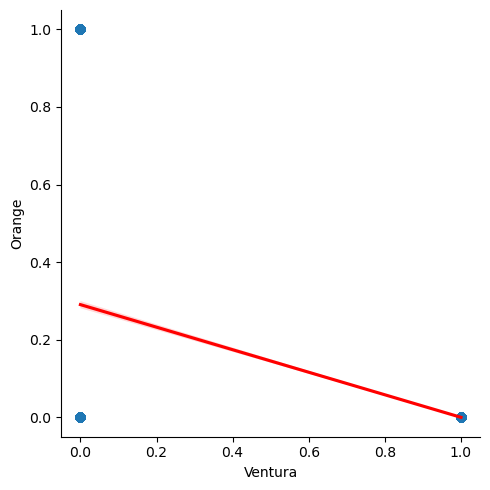

In [4]:
explore.plot_variable_pairs(train)

### These graphs are from zillow_predictions without dummy variables for fips

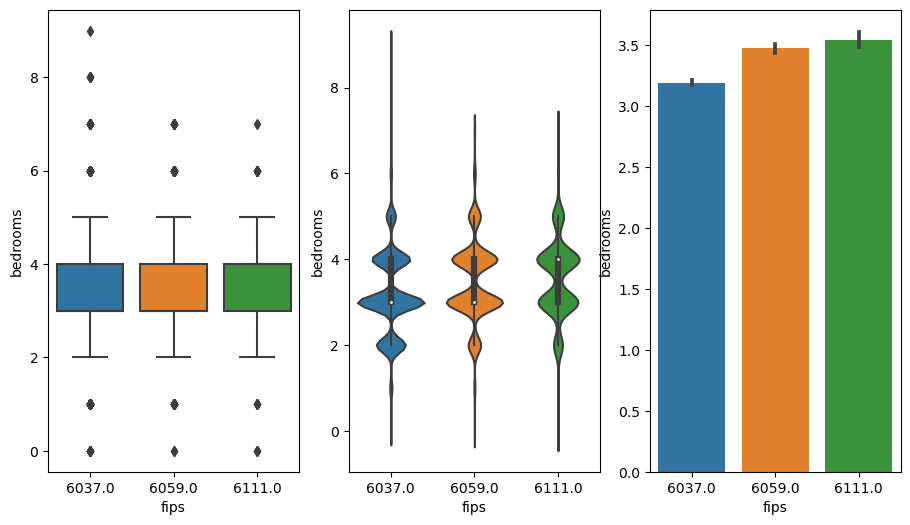

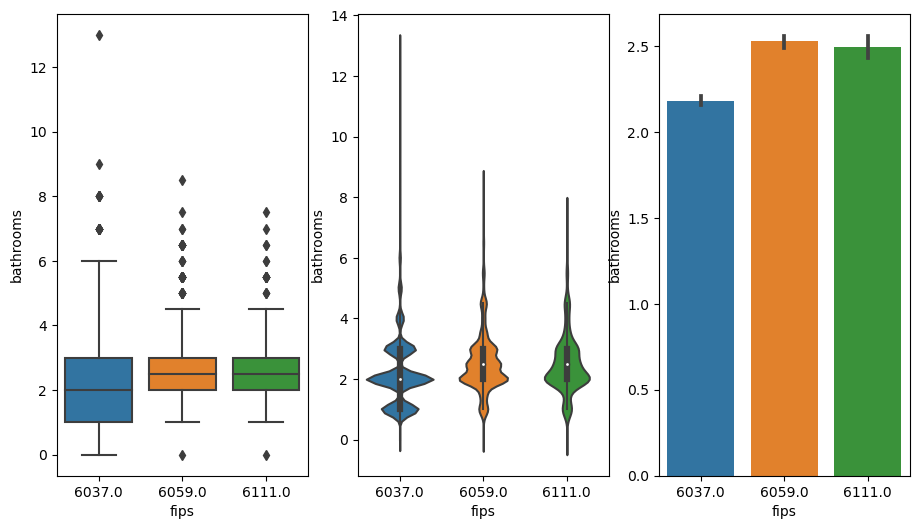

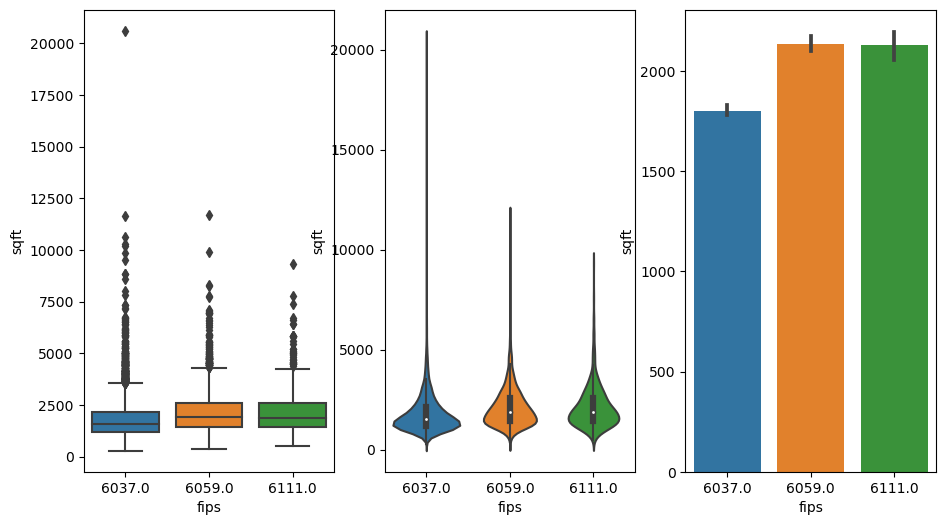

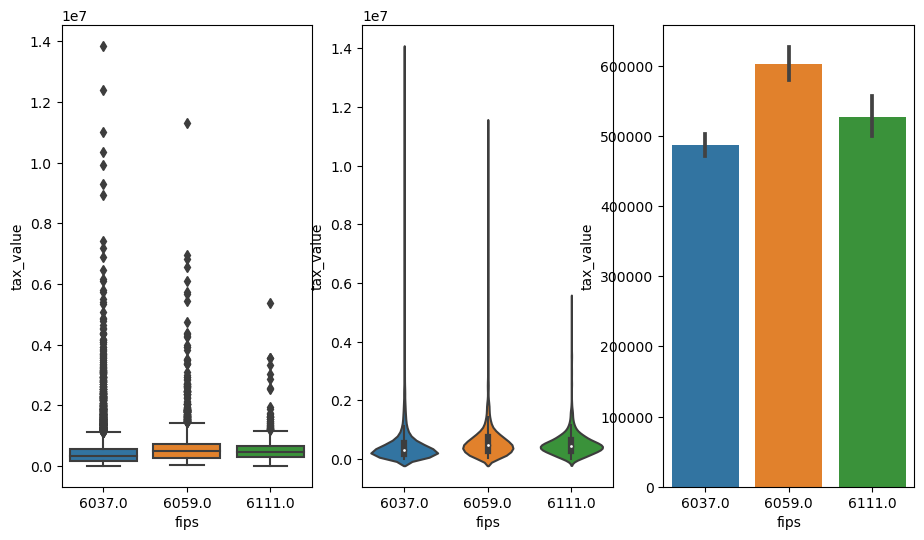

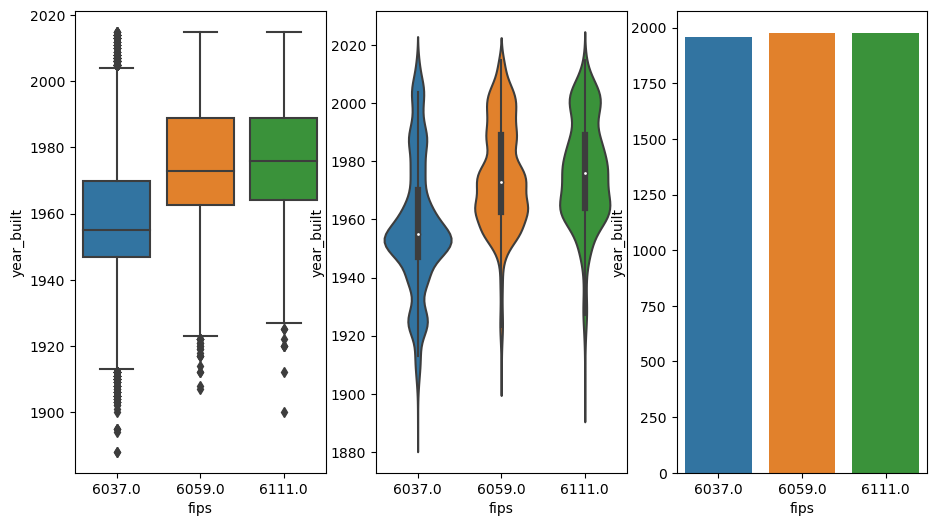

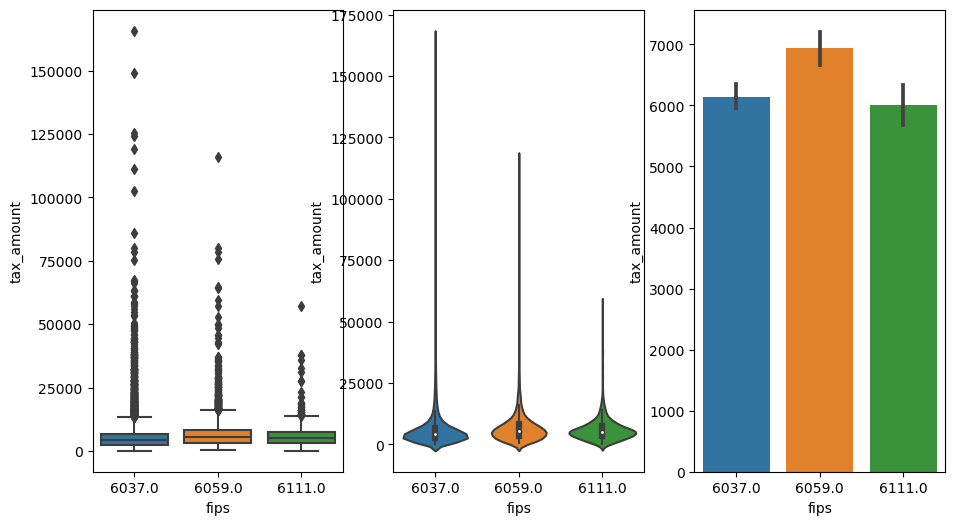

In [11]:
explore.plot_categorical_and_continuous_vars(zillow_categorical, sample_size=10000)

In [ ]:
explore.correlation_heatmap(train)

Bathrooms are highly correlated with square feet so for linear regression I will take one out.  Judging by the heat map sqft is better correlated with our target of tax value so that is the one I will keep it over bathrooms and bedrooms in our past MVP.  Year built is also correlated with sqft so i might have another thing to say.  Maybe choose bedrooms and year built.

In [ ]:
X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp, X_test_mvp, y_test_mvp = explore.mvp_split(train, validate, test)

print(explore.select_kbest(X_train_mvp, y_train_mvp, n=3))
print(explore.rfe(X_train_mvp, y_train_mvp, n=3))

### This lends further creedence to the guess that these three columns should be combined into one in later linear Regression

In [ ]:
y_train_mvp, y_validate_mvp, y_test_mvp, rmse_train_mvp_median, rmse_validate_mvp_median = explore.baseline_rmse(y_train_mvp, y_validate_mvp, y_test_mvp)

In [ ]:
y_train_mvp, y_validate_mvp, rmse_train_mvp_lm, rmse_validate_mvp_lm = explore.linear_regression(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp)

In [ ]:
y_train_mvp, y_validate_mvp, rmse_train_mvp_lars, rmse_validate_mvp_lars = explore.lasso_lars(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp)

In [ ]:
y_train_mvp, y_validate_mvp, rmse_train_mvp_quad, rmse_validate_mvp_quad, rmse_test_mvp_quad = explore.quadratic_regression(X_train_mvp, y_train_mvp, X_validate_mvp, y_validate_mvp, X_test_mvp, y_test_mvp)

In [ ]:
# metrics in a dataframe

metric_df = pd.DataFrame(data = [
        {
            "model": "mean_baseline",
            "RMSE_train": rmse_train_mvp_median,
            "RMSE_validate":rmse_validate_mvp_median,
            "R2_validate": 0
        },
        {
            "model": "Linear Regression",
            "RMSE_train": rmse_train_mvp_lm,
            "RMSE_validate":rmse_validate_mvp_lm,
            "R2_validate": (rmse_train_mvp_median - rmse_validate_mvp_lm) / rmse_train_mvp_median
        },
        {
            "model": "LassoLars alpha=10",
            "RMSE_train": rmse_train_mvp_lars,
            "RMSE_validate":rmse_validate_mvp_lars,
            "R2_validate": (rmse_train_mvp_median - rmse_validate_mvp_lars) / rmse_train_mvp_median
        },
        {
            "model": "Quadratic Regression",
            "RMSE_train": rmse_train_mvp_quad,
            "RMSE_validate":rmse_validate_mvp_quad,
            "R2_validate": (rmse_train_mvp_median - rmse_validate_mvp_quad) / rmse_train_mvp_median
        }
])

metric_df

In [ ]:
print("RMSE for Quadratic Model \nTest: ", rmse_test_mvp_quad)

In [ ]:
print("R2 for Quadratic Model: ", (rmse_train_mvp_median - rmse_test_mvp_quad) / rmse_train_mvp_median)